# Recipe Recommendation System
Creating, Testing, and Tuning Unsupervised Learning Methods to Recommend Relevant Recipes

Detailed Workflow:  

1.Data Loading and Aggregation:  
    -Load raw recipe data from Allrecipes.com, epicurious.com, and foodnetwork.com.  
    -Process and transpose data into a unified format for analysis.
    
2.Data Cleaning and Preprocessing:  
    -Clean data to remove empty cells and inadequate recipe information.  
    -Identify and handle null values, ensuring robustness in data.  
    -Normalize ingredient lists and remove extraneous content like 'ADVERTISEMENT'.  
    -Perform lemmatization and stop-word removal to prepare for advanced text processing.
       
3.Feature Engineering and Text Transformation:   
    -Combine recipe titles, ingredients, and instructions into a singular text representation.   
    -Apply cleaning methods such as punctuation and digit removal, whitespace normalization.   
    -Transform cleaned text using TF-IDF vectorization for further analysis.

4.Exploratory Data Analysis:  
    -Analyze the distribution of ingredients, instruction lengths, and other textual features.  
    -Use visualizations like histograms and word clouds to gain insights into the dataset.

5.Topic Modeling and Comparison:  
    -Compare Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NNMF) for topic extraction.  
    -Investigate the distribution of documents across different topics to assess model performance.

6.Keyword Generation Using TextRank:
    -Implement TextRank for keyword summarization to derive descriptive categories from topics.  
    -Refine the keyword generation process to increase the relevance and accuracy of the extracted keywords.  

7.Recipe Similarity and Search Algorithm:  
    -Develop an algorithm utilizing cosine similarity to sort recipes based on user-input queries.  
    -Include additional features such as recipe categories and tags for enhanced search functionality.

8.Model Evaluation and Fine-tuning:  
    -Assess the performance of the topic models and the search algorithm.  
    -Optimize model parameters based on evaluation outcomes and experimentation.  

9.Integration of Image Data (Future Scope):  
    -Consider the possibility of utilizing recipe images to augment model performance.  
    -Explore neural network-based approaches for category prediction based on images.

10.Final System Implementation and Testing:  
    -Integrate all components into a coherent system for recipe recommendation.  
    -Conduct thorough testing to ensure accuracy and reliability of the recommendations.  


-----



### Overview of the Dataset
The dataset for the Recipe Recommendation System is a comprehensive collection of culinary recipes sourced from three major cooking websites: Allrecipes.com, epicurious.com, and foodnetwork.com. This diverse dataset includes a wide range of recipes, encompassing various cuisines, cooking techniques, and ingredient combinations.

Data Sources
Allrecipes.com: A popular platform offering a vast array of user-submitted recipes.   
Epicurious.com: Known for its sophisticated and professionally tested recipes.    
Foodnetwork.com: Features recipes from famous chefs and cooking shows.

Data Content   
Each recipe in the dataset includes:

Title: The name of the recipe.   
Ingredients: A list of ingredients required for the recipe.   
Instructions: Step-by-step cooking instructions.   

In [1]:
from itertools import repeat
import pandas as pd
import numpy as np
import spacy
from functools import reduce
from operator import add
import string
import re
import multiprocessing as mp
import matplotlib.pyplot as plt
import networkx as nx
import time
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
load_json = lambda file_path: pd.read_json(file_path)
allrecipes_raw = load_json('/content/recipe_file_one.json')
epicurious_raw = load_json('/content/recipe_file_two.json')
foodnetwork_raw = load_json('/content/recipe_file_three.json')

In [3]:
process_dataframe = lambda df: df.transpose().reset_index(drop=True).rename_axis(None, axis=1)

allrecipes = process_dataframe(allrecipes_raw)
epicurious = process_dataframe(epicurious_raw)
foodnetwork = process_dataframe(foodnetwork_raw)

In [4]:
get_first_row = lambda df: df.head(1)
allrecipes_first_row = get_first_row(allrecipes)
allrecipes_first_row

,title,ingredients,instructions,picture_link
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S


In [5]:
get_first_row = lambda df: df.head(1)
epicurious_first_row = get_first_row(epicurious)
epicurious_first_row


,ingredients,picture_link,instructions,title
0,"[12 egg whites, 12 egg yolks, 1 1/2 cups sugar...",None,"Beat the egg whites until stiff, gradually add...",Christmas Eggnog


In [6]:
get_first_row = lambda df: df.head(1)
foodnetwork_first_row = get_first_row(foodnetwork)
foodnetwork_first_row

,instructions,ingredients,title,picture_link
0,Toss ingredients lightly and spoon into a butt...,"[1/2 cup celery, finely chopped, 1 small green...",Grammie Hamblet's Deviled Crab,None


In [7]:
reset_indices = lambda df: df.reset_index(drop=True)
recipes = reset_indices(pd.concat([allrecipes, epicurious, foodnetwork]))
recipes_shape = recipes.shape
recipes_shape

(125164, 4)

In [8]:
count_missing_values = lambda df: df.apply(lambda x: x.isna().sum())
missing_values_count = count_missing_values(recipes)
missing_values_count

title             569
ingredients       517
instructions      691
picture_link    42571
dtype: int64

In [9]:
count_columns_with_missing = lambda df: df.apply(lambda x: x.isna().any())
null_recs = count_columns_with_missing(recipes.drop(columns='picture_link').transpose())
null_recs_sum = null_recs.sum()
null_recs_sum

691

In [10]:
filter_null_columns = lambda df, null_recs: df[null_recs]
null_columns_df = filter_null_columns(recipes, null_recs)
null_columns_df_head = null_columns_df.head()
null_columns_df_head

,title,ingredients,instructions,picture_link
5874,NaN,NaN,NaN,NaN
15020,NaN,NaN,NaN,NaN
15023,NaN,NaN,NaN,NaN
15025,NaN,NaN,NaN,NaN
15637,NaN,NaN,NaN,NaN


In [11]:
drop_rows_and_reset_index = lambda df, null_recs: df.drop(index=df[null_recs].index).reset_index(drop=True)
recipes = drop_rows_and_reset_index(recipes, null_recs)
recipes_shape = recipes.shape
recipes_shape

(124473, 4)

In [12]:
get_data_types = lambda df: df.dtypes
data_types = get_data_types(recipes)
data_types

title           object
ingredients     object
instructions    object
picture_link    object
dtype: object

In [13]:
nc_ingred_index = []
nc_title_index = []
nc_instr_index = []
for index, ingredients, title, instructions in zip(
    recipes.index, recipes['ingredients'], recipes['title'], recipes['instructions']
):
    if all(j.isdigit() or j in string.punctuation for j in ingredients):
        nc_ingred_index.append(index)
    if all(j.isdigit() or j in string.punctuation for j in title):
        nc_title_index.append(index)
    if all(j.isdigit() or j in string.punctuation for j in instructions):
        nc_instr_index.append(index)

In [14]:
index_list = [nc_ingred_index, nc_title_index, nc_instr_index]
lengths = []
for x in index_list:
    lengths.append(len(x))
lengths

[1520, 0, 39]

In [15]:
index_list = [nc_ingred_index, nc_title_index, nc_instr_index]

inds_to_drop = set(reduce(lambda x, y: x + y, index_list))
print(len(inds_to_drop))

1551


In [16]:
recipes = recipes.drop(index=inds_to_drop).reset_index(drop=True)
recipes.shape

(122922, 4)

In [17]:
empty_instr_ind = []
for index, instructions in zip(recipes.index, recipes['instructions']):
    if len(instructions) < 20:
        empty_instr_ind.append(index)

recipes = recipes.drop(index=empty_instr_ind).reset_index(drop=True)

In [18]:
recipes.shape

(122911, 4)

In [19]:
low_ingr_index = []
low_ingr_values = []
for index, ingredients in zip(recipes.index, recipes['ingredients']):
    if pd.isna(ingredients[0]):
        low_ingr_index.append(index)
        low_ingr_values.append(ingredients)
num_low_ingr = len(low_ingr_index)
print(recipes.loc[low_ingr_index, 'ingredients'])

Series([], Name: ingredients, dtype: object)


In [20]:
pseudo_empty_index = []
for index, ingredients in zip(recipes.index, recipes['ingredients']):
    if pd.isna(np.nan in ingredients):
        pseudo_empty_index.append(index)
print(pseudo_empty_index)

[]


### Data Preparation for Tokenization

Key Steps in Data Cleaning:
- Extraction of Advertisements: Rigorous removal of any 'ADVERTISEMENT' tags embedded within the recipe texts, ensuring the purity of the culinary content.
- Dataset Pruning: Diligent elimination of rows containing empty fields or recipes lacking sufficient detail, thereby enhancing the overall quality and reliability of the dataset.
- Textual Normalization: Systematic stripping away of all forms of punctuation and numerical figures, alongside the reduction of redundant spaces. This step is crucial in achieving a standardized textual format conducive to effective tokenization.

In [21]:
ingredients = []
for ing_list in recipes['ingredients']:
    try:
        clean_ings = [ing.replace('ADVERTISEMENT', '').strip() for ing in ing_list if ing is not None]
        if '' in clean_ings:
            clean_ings.remove('')
        ingredients.append(clean_ings)
    except AttributeError:
        ingredients.append(ing_list)
recipes['ingredients'] = ingredients

In [22]:
get_ingredients = lambda df, row: df.loc[row, 'ingredients']
ingredients_row_0 = get_ingredients(recipes, 0)
ingredients_row_0

['4 skinless, boneless chicken breast halves',
 '2 tablespoons butter',
 '2 (10.75 ounce) cans condensed cream of chicken soup',
 '1 onion, finely diced',
 '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces']

In [23]:
ingredient_text = []
for ingredients in recipes['ingredients']:
    ingredient_text.append('; '.join(ingredients))
recipes['ingredient_text'] = ingredient_text
ingredient_text_head = recipes['ingredient_text'].head()
ingredient_text_head

0    4 skinless, boneless chicken breast halves; 2 ...
1    2 (10.75 ounce) cans condensed cream of mushro...
2    1/2 cup packed brown sugar; 1/2 cup ketchup; 1...
3    1 cup butter, softened; 1 cup white sugar; 1 c...
4    8 ounces whole wheat rotini pasta; 3 cups fres...
Name: ingredient_text, dtype: object

In [24]:
ingredient_count = []
for ingredients in recipes['ingredients']:
    ingredient_count.append(len(ingredients))
recipes['ingredient_count'] = ingredient_count

In [25]:
recipes.head(1)

,title,ingredients,instructions,picture_link,ingredient_text,ingredient_count
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves, 2...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S,"4 skinless, boneless chicken breast halves; 2 ...",5


In [26]:
all_text = recipes['title'] + ' ' + recipes['ingredient_text'] + ' ' + recipes['instructions']
all_text[0]

'Slow Cooker Chicken and Dumplings 4 skinless, boneless chicken breast halves; 2 tablespoons butter; 2 (10.75 ounce) cans condensed cream of chicken soup; 1 onion, finely diced; 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n'

In [27]:
def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        try:
            if isinstance(doc, str):
                doc = doc.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
                doc = re.sub(r'\d+', '', doc) # Remove Digits
                doc = doc.replace('\n', ' ') # Remove New Lines
                doc = doc.strip() # Remove Leading White Space
                doc = re.sub(' +', ' ', doc) # Remove multiple white spaces
                cleaned_text.append(doc)
            else:
                cleaned_text.append('')
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            cleaned_text.append('')
    return cleaned_text
cleaned_text = clean_text(all_text)

In [28]:
cleaned_text[2]

'Brown Sugar Meatloaf cup packed brown sugar cup ketchup pounds lean ground beef cup milk eggs teaspoons salt teaspoon ground black pepper small onion chopped teaspoon ground ginger cup finely crushed saltine cracker crumbs Preheat oven to degrees F degrees C Lightly grease a x inch loaf pan Press the brown sugar in the bottom of the prepared loaf pan and spread the ketchup over the sugar In a mixing bowl mix thoroughly all remaining ingredients and shape into a loaf Place on top of the ketchup Bake in preheated oven for hour or until juices are clear'

### Tokenizing Using Spacy

Approach to tokenization:
- Lemmatization of Words: In this stage, we apply lemmatization to each word in our dataset. Lemmatization is the process of reducing words to their base or root form. This step is essential for creating more compact and effective word embeddings, which are crucial for the subsequent machine learning processes.
- Focused Tokenization: While tokenizing the text, our approach will specifically involve the lemmatization of words. However, it's important to note that we will not incorporate Part-Of-Speech (POS) tagging, recognition of known entities, or parsing of noun phrases. This selective approach to tokenization aims to streamline the data while retaining the most significant elements for our recipe recommendation system.

In [29]:
nlp = spacy.load('en_core_web_sm')
lemmatized_text = ' '.join([token.lemma_ for token in nlp(cleaned_text[2]) if not token.is_stop])
lemmatized_text

'Brown Sugar Meatloaf cup pack brown sugar cup ketchup pound lean ground beef cup milk egg teaspoon salt teaspoon grind black pepper small onion chop teaspoon ground ginger cup finely crush saltine cracker crumb Preheat oven degree F degree C lightly grease x inch loaf pan Press brown sugar prepared loaf pan spread ketchup sugar mix bowl mix thoroughly remain ingredient shape loaf Place ketchup Bake preheat oven hour juice clear'

In [30]:
def text_tokenizer(documents):
    tokenized_documents = []
    for doc in documents:
        try:
            tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
            tokenized_documents.append(tok_doc)
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            tokenized_documents.append('')  # Handle exceptions with an empty string
    return tokenized_documents

In [31]:
def text_tokenizer_mp(doc):
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [32]:
nlp = spacy.load('en_core_web_sm')
def batch_tokenize(documents, max_iterations=None):
    tokenized_docs = []
    try:
        for count, doc in enumerate(nlp.pipe(documents, disable=["parser", "ner"])):
            if max_iterations and count >= max_iterations:
                break  # Stop after processing max_iterations documents
            tokens = [token.lemma_ for token in doc if not token.is_stop]
            tokenized_docs.append(' '.join(tokens))
    except Exception as e:
        print(f"An error occurred: {str(e)}")
    return tokenized_docs
max_docs = 1000
tokenized_text = batch_tokenize(cleaned_text, max_iterations=max_docs)

In [33]:
pd.Series(tokenized_text).to_csv('tokenized_text.csv')

In [34]:
tokenized_text[0]

'Slow Cooker Chicken Dumplings skinless boneless chicken breast half tablespoon butter ounce can condense cream chicken soup onion finely dice ounce package refrigerate biscuit dough tear piece place chicken butter soup onion slow cooker fill water cover Cover cook hour High minute serve place tear biscuit dough slow cooker Cook dough long raw center'

### Development of Word Embeddings for Enhanced Text Analysis

Strategies for Embedding Generation:  
- TF-IDF Implementation: Utilization of Term Frequency-Inverse Document Frequency (TF-IDF) to transform the textual data, ensuring that each word's importance is reflected in its numerical representation.
- Exploration of GloVe Embeddings: Integration of pre-trained GloVe (Global Vectors for Word Representation) embeddings, alongside a custom training approach on our recipe dataset, aiming to capture the unique culinary context.
- Customized GloVe Training: In addition to pre-trained models, we endeavor to train GloVe embeddings specifically on our recipe corpus to capture the unique linguistic nuances of culinary text.

In [35]:
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1))
text_tfidf = vectorizer.fit_transform(tokenized_text)
tfidf_words = vectorizer.get_feature_names_out()
print(text_tfidf.shape)
print(len(tfidf_words))

(1000, 2353)
2353


### Implementing Topic Modeling Techniques

Chosen Methods for Topic Modeling:

- Latent Dirichlet Allocation (LDA): Employing LDA to discover latent topics within our collection of recipes. This method helps in uncovering underlying thematic structures.
- Non-negative Matrix Factorization (NNMF): Utilizing NNMF for its efficacy in decomposing the high-dimensional recipe data into identifiable topics.

------

### Objectives and Application:  
The core objective of implementing these topic modeling techniques is to systematically categorize the recipes into coherent groups. By identifying similar subgroups within the text, we aim to:

- Generate a set of category-defining words for each group using TextRank.
- Use these categorizations to enhance the precision of our recipe recommendation queries.

In [36]:
text_tfidf.shape

(1000, 2353)

In [37]:
n_components = 50
max_iter = 100
lda = LDA(n_components=n_components, n_jobs=-1, max_iter=max_iter)
text_lda = lda.fit_transform(text_tfidf)
text_lda_shape = text_lda.shape
text_lda_shape

(1000, 50)

In [38]:
init = 'nndsvdar'
l1_ratio = 0.0
max_iter = 100
n_components = 50
solver = 'cd'
nmf = NMF(init=init, l1_ratio=l1_ratio, max_iter=max_iter, n_components=n_components, solver=solver)
text_nmf = nmf.fit_transform(text_tfidf)
text_nmf_shape = text_nmf.shape
text_nmf_shape

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


(1000, 50)

### Integration with TextRank:
Both LDA and NNMF serve as foundational steps towards generating meaningful categories. Once topics are defined, we apply TextRank to extract key terms that best represent each topic. These terms are instrumental in refining the search and recommendation mechanisms within our system, ensuring users receive the most relevant recipe suggestions based on their interests.

### Selection of Topic Modeling Parameters and Future Directions
Determination of Model Parameters:
- Topic Count Specification: For the purpose of our initial analysis, we have chosen to set the number of topics to 50 in both the NNMF and LDA models. This decision, while somewhat arbitrary, serves as a starting point for our exploration into topic modeling.
- Limitations in Variance Analysis: It's noteworthy that both NNMF and LDA models lack the capability to quantify the percentage of variance they encapsulate from the original TF-IDF matrix. Consequently, the selection of 50 topics represents an exploratory choice rather than one grounded in precise statistical rationale.

### Forthcoming Analytical Steps:
As we progress, our focus will pivot to two critical matrices that will further shape our understanding and use of the extracted topics:

- Document-Topic Matrix
- Word-Topic Matrix

In [39]:
# variable dependencies:
text_series = pd.Series(all_text)
file_path = 'text_data.csv'

# Save the Series to a CSV file
text_series.to_csv(file_path, index=False)

def docs_by_tops(top_mat, topic_range=(0, 0), doc_range=(0, 2)):
    try:
        for i in range(topic_range[0], topic_range[1]):
            try:
                topic_scores = pd.Series(top_mat[:, i])
                doc_index = topic_scores.sort_values(ascending=False)[doc_range[0]:doc_range[1]].index
                for j, index in enumerate(doc_index, doc_range[0]):
                    try:
                        print('Topic #{}'.format(i),
                              '\nDocument #{}'.format(j),
                              '\nTopic Score: {}\n\n'.format(topic_scores[index]),
                              text_series[index], '\n\n')
                    except Exception as e_inner:
                        print(f"An error occurred in inner loop: {str(e_inner)}")
            except Exception as e_middle:
                print(f"An error occurred in middle loop: {str(e_middle)}")
    except Exception as e_outer:
        print(f"An error occurred in outer loop: {str(e_outer)}")

In [40]:
file_path = 'text_data.csv'
df = pd.read_csv(file_path)
print(df)

                                                        0
0       Slow Cooker Chicken and Dumplings 4 skinless, ...
1       Awesome Slow Cooker Pot Roast 2 (10.75 ounce) ...
2       Brown Sugar Meatloaf 1/2 cup packed brown suga...
3       Best Chocolate Chip Cookies 1 cup butter, soft...
4       Homemade Mac and Cheese Casserole 8 ounces who...
...                                                   ...
122906  Summer Corn Salad 4 ears fresh corn; 2 heads B...
122907  Zucchini Stuffed Tomatoes 4 large plum tomatoe...
122908  Pepper Pasta Quick Cook 3 tablespoons olive oi...
122909  Chocolate Cake with Armagnac Ice Cream 8 ounce...
122910  Crabby Bisque 3 (10.5-ounce) cans restaurant-s...

[122911 rows x 1 columns]


In [41]:
text_series

0         Slow Cooker Chicken and Dumplings 4 skinless, ...
1         Awesome Slow Cooker Pot Roast 2 (10.75 ounce) ...
2         Brown Sugar Meatloaf 1/2 cup packed brown suga...
3         Best Chocolate Chip Cookies 1 cup butter, soft...
4         Homemade Mac and Cheese Casserole 8 ounces who...
                                ...                        
122906    Summer Corn Salad 4 ears fresh corn; 2 heads B...
122907    Zucchini Stuffed Tomatoes 4 large plum tomatoe...
122908    Pepper Pasta Quick Cook 3 tablespoons olive oi...
122909    Chocolate Cake with Armagnac Ice Cream 8 ounce...
122910    Crabby Bisque 3 (10.5-ounce) cans restaurant-s...
Length: 122911, dtype: object

In [42]:
docs_by_tops(text_lda,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.28679662869976924

 Robbi's M&Ms;® Cookies 1 cup packed brown sugar; 1/2 cup white sugar; 1 cup shortening; 2 eggs; 1 1/2 teaspoons vanilla extract; 2 1/2 cups all-purpose flour; 1 teaspoon baking soda; 1 teaspoon salt; 1 1/2 cups candy-coated milk chocolate pieces (such as M&M;'s®) In a large bowl, mix sugar, eggs, shortening, and vanilla thoroughly. Add flour, salt, and baking soda to creamed mixture. Blend well. Add 3/4 cup candies.
Drop dough by teaspoonful onto baking sheet. Slightly push a few candies on top of each dough ball with remaining candies.
Bake at 350 degrees F (175 degrees C) for 9 to 11 minutes.
 


Topic #0 
Document #1 
Topic Score: 0.21206996793829855

 Dumplings 1 cup all-purpose flour; 2 teaspoons baking powder; 1 teaspoon white sugar; 1/2 teaspoon salt; 1 tablespoon margarine; 1/2 cup milk Stir together flour, baking powder, sugar, and salt in medium size bowl. Cut in butter until crumbly. Stir in milk to make a soft dough.

In [43]:
docs_by_tops(text_nmf,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.07494518257788631

 Pollo Fajitas 1 tablespoon Worcestershire sauce; 1 tablespoon cider vinegar; 1 tablespoon soy sauce; 1 teaspoon chili powder; 1 clove garlic, minced; 1 dash hot pepper sauce; 1 1/2 pounds boneless, skinless chicken thighs, cut into strips; 1 tablespoon vegetable oil; 1 onion, thinly sliced; 1 green bell pepper, sliced; 1/2 lemon, juiced In a medium bowl, combine Worcestershire sauce, vinegar, soy sauce, chili powder, garlic and hot pepper sauce. Place chicken in sauce, and turn once to coat. Marinate for 30 minutes at room temperature, or cover and refrigerate for several hours.
Heat oil in a large skillet over high heat. Add chicken strips to the pan, and saute for 5 minutes. Add the onion and green pepper, and saute another 3 minutes. Remove from heat, and sprinkle with lemon juice.
 


Topic #0 
Document #1 
Topic Score: 0.0688071365223045

 Sweet, Sticky and Spicy Chicken 1 tablespoon brown sugar; 2 tablespoons honey; 1/4 cu

### Exploring Topics by words

In [44]:
text_nmf.shape

(1000, 50)

In [45]:
text_tfidf.T.shape

(2353, 1000)

In [46]:
# Function for best topic words using cosine similarity
# Variable Dependency:
word_series = pd.Series(tfidf_words)

def words_by_tops(tfidf_mat, top_mat, topic_range=(0, 0), n_words=10):
    try:
        topic_word_scores = tfidf_mat.T * top_mat
        for i in range(topic_range[0], topic_range[1]):
            try:
                word_scores = pd.Series(topic_word_scores[:, i])
                word_index = word_scores.sort_values(ascending=False)[:n_words].index
                print('\nTopic #{}'.format(i))
                for index in word_index:
                    try:
                        print(word_series[index], '\t\t', word_scores[index])
                    except Exception as e_inner:
                        print(f"An error occurred in inner loop: {str(e_inner)}")
            except Exception as e_middle:
                print(f"An error occurred in middle loop: {str(e_middle)}")
    except Exception as e_outer:
        print(f"An error occurred in outer loop: {str(e_outer)}")

In [47]:
words_by_tops(text_tfidf, text_lda, (0,3), 10)


Topic #0
cup 		 0.505169951013973
teaspoon 		 0.3982291573460164
sugar 		 0.37699430890027946
bake 		 0.3571902073276894
flour 		 0.35532323459658477
powder 		 0.3048378893552963
butter 		 0.28294375040698105
degree 		 0.272618887483657
salt 		 0.2628265109091818
tablespoon 		 0.23486889823583984

Topic #1
cup 		 0.30990184328700204
teaspoon 		 0.2243691852432723
butter 		 0.21843762952757204
sugar 		 0.21558145332246187
chicken 		 0.20224238915979523
bake 		 0.1808819047146942
degree 		 0.17502852112704886
flour 		 0.16153122734530165
salt 		 0.15486268329902517
stir 		 0.15196467844362369

Topic #2
cup 		 0.3188464770395735
teaspoon 		 0.24001054589472368
chicken 		 0.189063309154118
flour 		 0.1886052398191284
salt 		 0.18223774162466844
sugar 		 0.1803026067724043
degree 		 0.17672399678564651
butter 		 0.16910876069938038
pepper 		 0.16784333288637585
bake 		 0.16578964895708137


In [48]:
words_by_tops(text_tfidf, text_nmf, (0,3), 10)


Topic #0
sauce 		 0.9190917093342328
chicken 		 0.46049978096467403
soy 		 0.4140258357814251
tablespoon 		 0.39033908941616763
pepper 		 0.3790779710500265
garlic 		 0.3361259951531057
cup 		 0.3306621119937327
teaspoon 		 0.32482644556417406
heat 		 0.2969390641170128
oil 		 0.2891369439047273

Topic #1
cup 		 2.8894108518827393
bake 		 2.6398008296242352
flour 		 2.579395222565353
sugar 		 2.2827927675469413
pan 		 2.1108905686248036
degree 		 2.0513013986564963
teaspoon 		 1.9967284856771657
soda 		 1.7818303329979095
egg 		 1.5853576114521086
oven 		 1.507980368394122

Topic #2
chicken 		 8.468742279907953
breast 		 2.755962585133484
pepper 		 1.9748623639344878
cup 		 1.8312405182404596
garlic 		 1.7592260129039214
cheese 		 1.7283816590167675
sauce 		 1.719791073491859
teaspoon 		 1.6211811564730791
heat 		 1.5931075547434117
skinless 		 1.5158152309439095


### Evaluation and Selection of Topic Modeling Outcomes  
Comparative Analysis of LDA and NNMF Models:  
After a detailed examination of the initial topics generated by both Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NNMF), a few observations have emerged:

- NNMF Performance: NNMF has demonstrated a notable ability to create more distinct and clearly defined topic models. Specifically, the top three topics identified were 0. Spreads, 1. Cakes, and 2. Chicken.
- LDA Insights: While LDA successfully generated coherent topics like 0. Salads and 1. Gravies, it faltered on the third topic, leaving its thematic focus unclear

### Utilizing TextRank for Topic Keyword Extraction  
Objective of TextRank in Our Analysis:

------------

TextRank, a graph-based ranking model, is employed in our system with the primary aim of extracting pivotal keywords from the topics identified by our models. This process is crucial for distilling the essence of each topic into a concise list of representative words.

Methodology and Considerations:  
- Corpora Size Management: Initially, we may experiment with a subset of the entire corpus for rapid development and testing. Once optimized, the same process will be applied to the full corpus.
- Evaluation of Document Inclusion:
    - We plan to start by summarizing the top 100 documents per topic. This selection will be evaluated and adjusted based on the results.
- Execution Strategy for TextRank:
    - To maintain simplicity, TextRank will be executed on the entire collection of selected topic corpora.
    - The approach of running TextRank individually on each topic and then aggregating the results will be considered for future refinement.
- Selection of Top Words:
    - Initially, the focus will be on the top 20 ranked words per topic, which will be subject to subsequent analysis and adjustment.
- Allocation of Keywords to Documents:
    - The decision on the number of documents to which these keywords will be assigned is anticipated to depend on the volume of documents contributing to each topic.
- Integration with Topic Models:
    - Post TextRank, a strategic decision will be made on whether to integrate the keywords extracted through NNMF, LDA, or a combination of both with TextRank for the most effective keyword extraction.

The purpose of using TextRank to extract keywords

------------

Consider using a smaller corpora size, so as to more quickly code. Then run the entire copora.
Using the time module to test out corpora sizes.

Using TextRank to summarize the topics by extracting words involves many variables:
- Deciding how many of the top documents each the topic should be summarized?
    - Arbitrarily: top 100, evaluate, then only decrease from there.
- Should TextRank then be performed once over the selected topic corpora, or should it be run individually and then scores added to make an aggregated rank?
    - For the sake of simplicity it should probably only be run over the entire corpora
- How many top ranked words should be used?
    - Check out the top ranks words first, then decide.
    - Arbitrarily choosing the top 20 ranked
- Then once keywords are decided, to how many documents should those words be assigned the extract?
    - I think it depends on the number of documents used to find the categorical keywords.
- Once we're satisfied with a TextRank strategy, we need to this about which method to use to extract topics (NNMF, LDA) as well as whether we'll NNMF, LDA, or TextRank to extract keywords.

In [49]:
sorted_indices = (-text_nmf[:, 1]).argsort()[:100]
text_4summary = pd.DataFrame({'text': cleaned_text})
text_4summary = text_4summary.iloc[sorted_indices]
recipe_stopwords = ['cup', 'cups', 'ingredient', 'ingredients', 'teaspoon', 'tablespoon', 'oven']
text_4summary['text'] = text_4summary['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in recipe_stopwords]))

In [50]:
start_time = time.time()
kw_filts = set()
try:
    for doc in text_4summary['text']:
        parsed_text = nlp(doc)
        for word in parsed_text:
            try:
                if word.pos_ in {'NOUN', 'ADJ', 'VERB'} and str(word) not in recipe_stopwords:
                    kw_filts.add(str(word))
            except Exception as e_inner:
                print(f"An error occurred in inner loop: {str(e_inner)}")
except Exception as e_outer:
    print(f"An error occurred in outer loop: {str(e_outer)}")
print('Execution Time: {} seconds'.format(time.time() - start_time))

Execution Time: 1.4694111347198486 seconds


### Simplified Approach to TextRank Implementation
Consolidation of Recipe Data:  
In our effort to streamline the TextRank process, we have chosen to merge all recipes into a singular, continuous corpus. This approach simplifies the execution of TextRank but introduces a notable consideration in the analysis:  

Challenge in Word Adjacency Analysis:  
- Adjacent Recipe Issue: Due to this consolidation, the boundary between individual recipes becomes indistinct. Consequently, words at the end of one recipe are treated as adjacent to those at the beginning of the next. This phenomenon potentially results in the creation of 'false' word adjacencies.
- Mitigating Factor: To counteract this, we've organized the recipes in a manner that aligns them according to their topic relevance. Such ordering implies that adjacent recipes are likely to be topically related, thus minimizing the impact of any artificial adjacencies created due to the concatenation.

In [51]:
len(kw_filts)

639

In [52]:
pd.Series(list(kw_filts)).nunique()

639

### Insights from Implementing TextRank in Keyword Extraction
Observations and Learnings:  
- Consistency in Filtered Keywords: A notable uniformity was observed in the keywords extracted from the top 100 recipes of each topic. This similarity indicates a strong thematic coherence within the recipes grouped under each topic.
- Necessity for Culinary-Specific Stopwords: There's a clear need to develop a tailored list of stopwords specific to culinary language. This will enhance the NLP process by filtering out common, yet contextually insignificant words in recipes.
- Relevance and Limitations of Extracted Keywords: While TextRank has proven effective in identifying keywords closely related to their respective topics, it falls short in abstractly generating semantically akin words that encapsulate the broader essence of each topic.
- Issue of False Adjacencies: The concatenation approach in preparing data for TextRank has led to the creation of some false adjacencies. Despite this, the keywords generated still align well with those identified through NNMF topic modeling, suggesting a minimal impact on the overall relevance of the results.
- Duplicate Word Rankings: A notable downside observed in the TextRank implementation is the recurrence of identical words with varying ranks. For instance, words like 'toothpick' or 'cups' appear multiple times with different rankings, indicating a need for refinement in the keyword extraction process.

### Assessment of Score Distribution in Topic Modeling
Objective of the Analysis:  
The focus of this analysis is to visually examine how document and word rankings are distributed across different topics. This examination is crucial for several reasons:

- Determining Topic Relevance: By analyzing the distribution of document topic scores, we aim to establish a cutoff point. This cutoff will help us identify which documents are most strongly associated with each respective topic.
- Refining Topic Categorization: The visualization of score distributions aids in understanding the strength and clarity of the topic-document relationships. This understanding is vital for ensuring that our topic models are accurately capturing the essence of the content within our corpus.

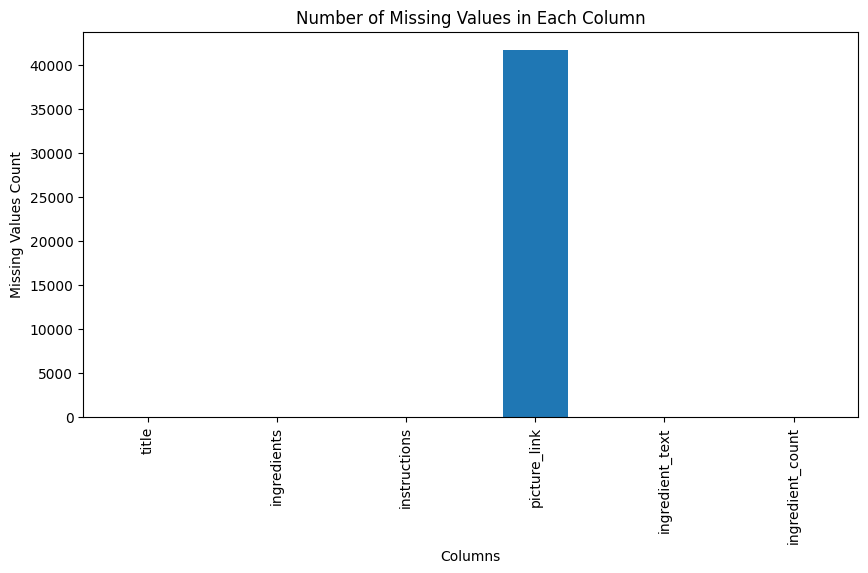

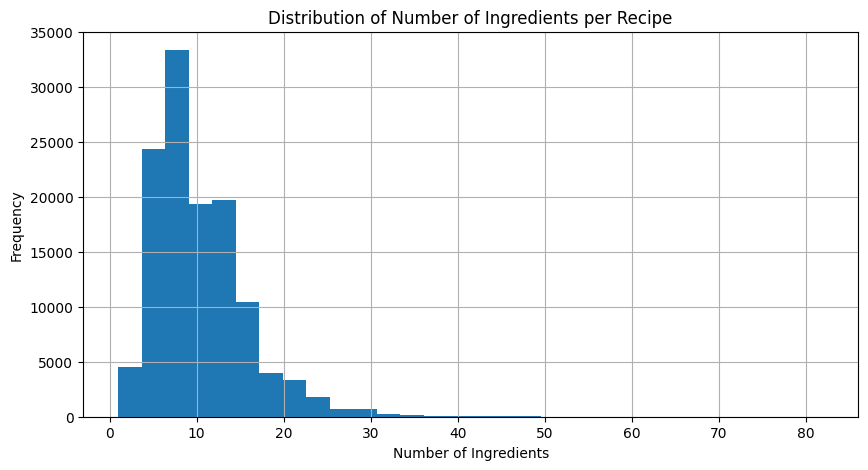

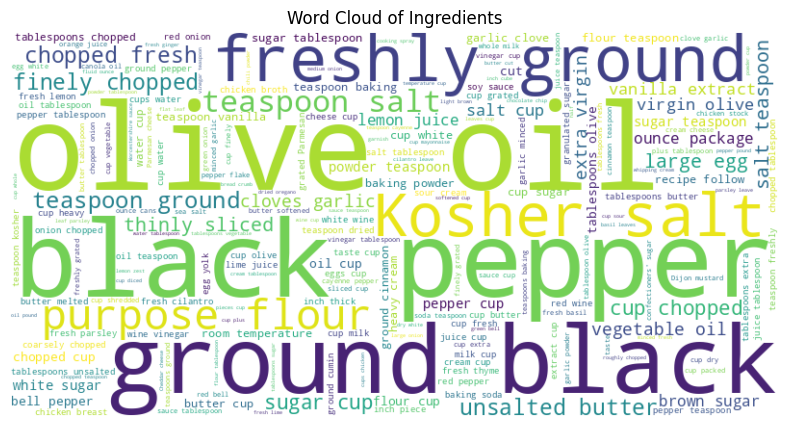

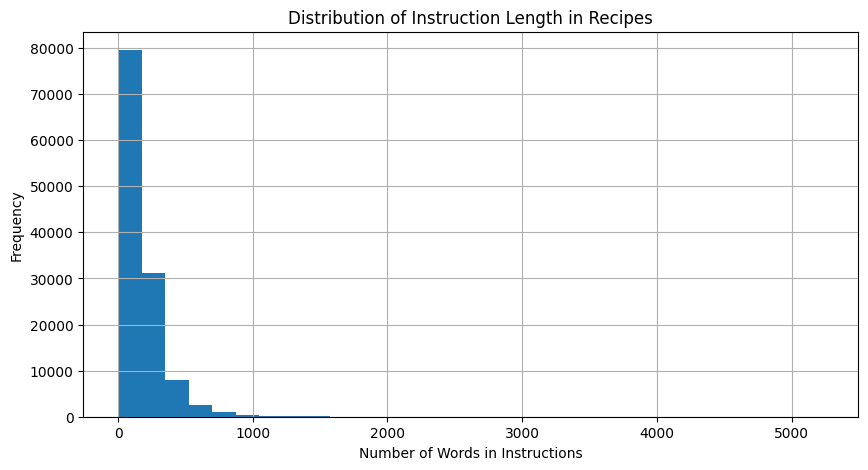

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

missing_values_count = recipes.apply(lambda x: x.isna().sum())
recipes['ingredient_count'] = recipes['ingredients'].apply(len)
all_ingredients = ' '.join([' '.join(ing) for ing in recipes['ingredients'] if ing])

plt.figure(figsize=(10, 5))
missing_values_count.plot(kind='bar')
plt.title('Number of Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Count')
plt.show()

plt.figure(figsize=(10, 5))
recipes['ingredient_count'].hist(bins=30)
plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Ingredients')
plt.show()

# Visualization 1: Length of Instructions
recipes['instruction_length'] = recipes['instructions'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
plt.figure(figsize=(10, 5))
recipes['instruction_length'].hist(bins=30)
plt.title('Distribution of Instruction Length in Recipes')
plt.xlabel('Number of Words in Instructions')
plt.ylabel('Frequency')
plt.show()




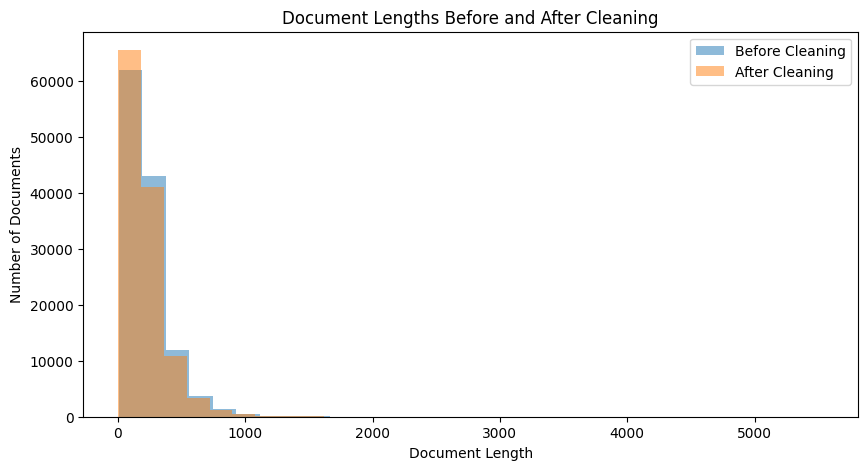

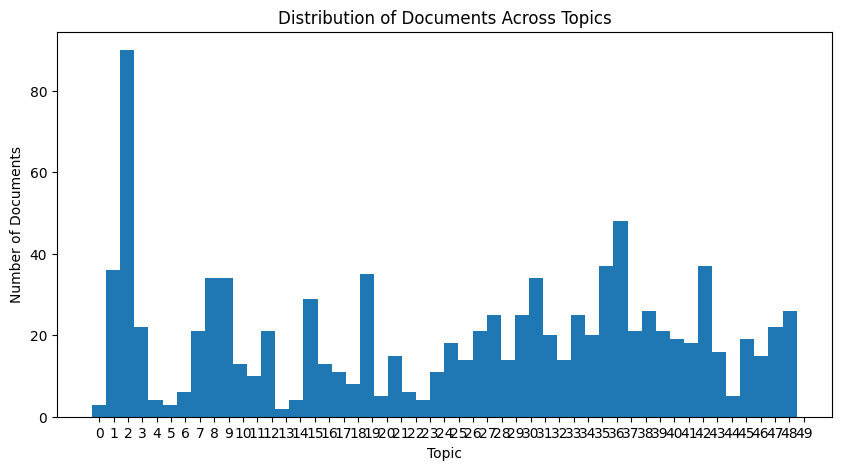

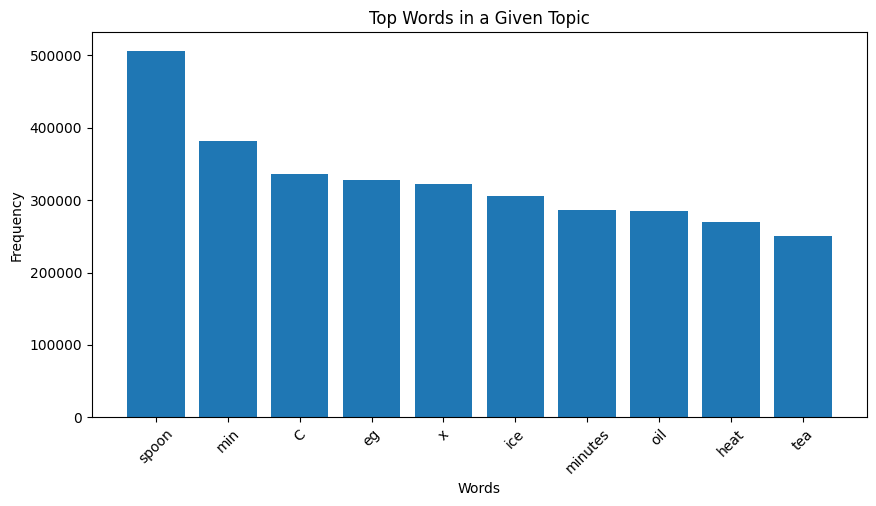

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'cleaned_text' and 'all_text' are lists of documents before and after cleaning
doc_lengths_before = [len(doc.split()) for doc in all_text]
doc_lengths_after = [len(doc.split()) for doc in cleaned_text]

plt.figure(figsize=(10, 5))
plt.hist(doc_lengths_before, bins=30, alpha=0.5, label='Before Cleaning')
plt.hist(doc_lengths_after, bins=30, alpha=0.5, label='After Cleaning')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.title('Document Lengths Before and After Cleaning')
plt.legend()
plt.show()

# Assuming 'text_lda' or 'text_nmf' is a document-topic matrix
# Here we are using 'text_nmf' as an example
doc_topic_distribution = np.argmax(text_nmf, axis=1)
plt.figure(figsize=(10, 5))
plt.hist(doc_topic_distribution, bins=len(set(doc_topic_distribution)), align='left')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Topics')
plt.xticks(range(len(set(doc_topic_distribution))))
plt.show()

# For Top Words in a Given Topic Visualization
# Assuming 'kw_filts' is a set of keywords and 'cleaned_text' is a list of cleaned documents
word_frequencies = {word: sum(doc.count(word) for doc in cleaned_text) for word in kw_filts}
top_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]

plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_words))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Words in a Given Topic')
plt.xticks(rotation=45)
plt.show()


In [55]:
text_lda

array([[0.00329413, 0.00329413, 0.00329413, ..., 0.00329413, 0.00329413,
        0.00329413],
       [0.00386651, 0.00386651, 0.00386651, ..., 0.00386651, 0.00386651,
        0.00386651],
       [0.00288824, 0.00288824, 0.00288824, ..., 0.00288824, 0.00288824,
        0.00288824],
       ...,
       [0.00264103, 0.00264103, 0.00264103, ..., 0.00264103, 0.00264103,
        0.00264103],
       [0.00364625, 0.00364625, 0.00364625, ..., 0.05014398, 0.00364625,
        0.00364625],
       [0.00248531, 0.00248531, 0.00248531, ..., 0.00248531, 0.00248531,
        0.00248531]])

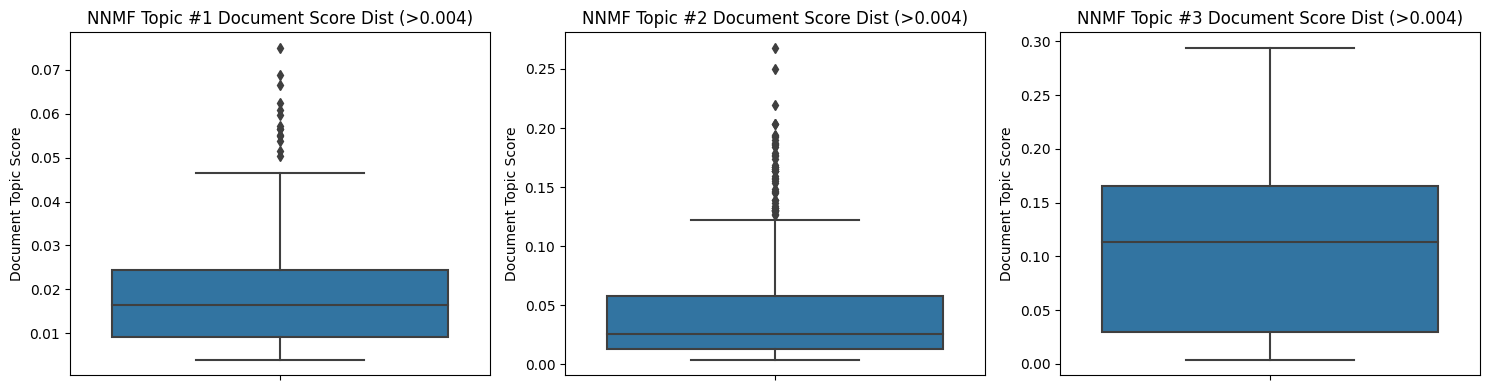

In [56]:
# Let's try a box plot visualization
plt.figure(figsize=(15, 4))
for i in range(3):
    series = pd.Series(text_nmf[:, i])
    series = series[series > 0.004]  # Apply the threshold as in the original code
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=series)
    plt.title('NNMF Topic #{} Document Score Dist (>0.004)'.format(i + 1))
    plt.ylabel('Document Topic Score')
plt.tight_layout()
plt.show()

### Innovative Approach to Analyzing Document Scores
Adoption of a Novel Methodology:  
In our exploration of topic modeling, we have adopted a unique approach that, while not previously utilized, draws inspiration from scree plot techniques. This involves:

- Elbow Plot Analysis: Creating plots that depict the scores of documents in relation to their aligned topics, arranged in descending order. These plots, akin to scree plots, help us visualize where the document scores start to level off - a point often referred to as the 'elbow.'
- Purpose of the Elbow Plots: The primary aim here is to discern the optimal number of documents that should be considered for each topic. By identifying where the scores plateau, we can more accurately determine the most relevant documents for topic representation.

Decision to Use NNMF:  
- Distinct Topic Convergence with NNMF: The decision to utilize Non-negative Matrix Factorization (NNMF) over Latent Dirichlet Allocation (LDA) was influenced by the clarity with which NNMF topics were defined. NNMF demonstrated a more pronounced and distinct convergence of documents around specific topics.
- Observations from Scree-Like Plots: Particularly for NNMF topics, it was observed that the document scores tend to stabilize around the top 200 documents. This observation has guided our choice to focus TextRank keyword extraction on these top 200 documents for each topic, ensuring a more targeted and relevant keyword generation.

As we approach the culmination of our project, we're focusing on:

- Reinitialization with Refined Parameters: The model will be reset with parameters that have been 'pseudo-optimized' based on our previous analyses and insights. This step is crucial for enhancing the model's performance and accuracy.
- Efficient Data Flow Management: By consolidating parameter adjustments in a singular location, we aim to streamline the flow and tracking of data throughout the system. This approach facilitates easier modifications and fine-tuning of the model's behavior.
- Creation of a Responsive Database: A dedicated database will be established to store processed data and model outputs. This database is designed to swiftly respond to user queries, ensuring an efficient and user-friendly experience.  

Code Management for Efficiency:
- Selective Code Execution: Certain segments of the code, particularly those that are computationally intensive, will be marked with a triple comment notation (''' '''). This marking serves as an indicator that these code blocks should only be executed in scenarios where the system resources and runtime considerations allow, such as when the computational kernel is not under heavy load.
- Purpose of Commented Code: This approach is adopted to balance the need for thorough computation against the practical constraints of system performance, especially during development and testing phases.

In [57]:
N_topics = 50
N_top_docs = 200
N_top_words = 25
N_docs_categorized = 2000
N_neighbor_window = 4
w_title = 0.2
w_text = 0.3
w_categories = 0.5
w_array = np.array([w_title, w_text, w_categories])
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','teaspoons','tablespoon',
                   'tablespoons','C','F']

In [58]:
topic_transformed_matrix = text_nmf
root_text_data = cleaned_text

### Creation and Allocation of Tags for Enhanced Document Categorization

In [59]:
def topic_docs_4kwsummary(topic_document_scores, root_text_data):
    text_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_top_docs].index
    text_4kwsummary = pd.Series(root_text_data)[text_index]
    return text_4kwsummary
def generate_filter_kws(text_list):
    parsed_texts = nlp(' '.join(text_list))
    kw_filts = set([str(word) for word in parsed_texts
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and word.lemma_ not in recipe_stopwords])
    return list(kw_filts), parsed_texts
def generate_adjacency(kw_filts, parsed_texts):
    unique_kw_filts = list(set(kw_filts))
    adjacency = pd.DataFrame(index=unique_kw_filts, columns=unique_kw_filts).fillna(0)
    for i, word in enumerate(parsed_texts):
        word_str = str(word)
        if word_str in unique_kw_filts:
            end = min(len(parsed_texts), i + N_neighbor_window + 1)  # Neighborhood Window Utilized Here
            nextwords = parsed_texts[i + 1:end]
            neighbors = [str(nextwords[j]) for j in range(len(nextwords)) if str(nextwords[j]) in unique_kw_filts]
            for neighbor in neighbors:
                adjacency.at[word_str, neighbor] += 1
    return adjacency
def generate_wordranks(adjacency):
    nx_words = nx.from_numpy_array(adjacency.values)
    ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)
    return ranks
def generate_tag_list(ranks):
    rank_values = [i for i in ranks.values()]
    ranked = pd.DataFrame(zip(rank_values, list(kw_filts))).sort_values(by=0,axis=0,ascending=False)
    kw_list = ranked.iloc[:N_top_words,1].to_list()
    return kw_list
def generate_tags(topic_document_scores, root_text_data):
    text_4kwsummary = topic_docs_4kwsummary(topic_document_scores, root_text_data)
    kw_filts, parsed_texts = generate_filter_kws(text_4kwsummary)
    adjacency = generate_adjacency(kw_filts, parsed_texts)
    ranks = generate_wordranks(adjacency)
    kw_list = generate_tag_list(ranks)
    return kw_list
def generate_kw_index(topic_document_scores):
    kw_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_docs_categorized].index
    return kw_index

In [60]:
if 'tag_list' not in recipes.columns:
    recipes['tag_list'] = [[] for _ in range(recipes.shape[0])]
try:
    for i in range(topic_transformed_matrix.shape[1]):
        try:
            scores = topic_transformed_matrix[:, i]
            topic_kws = generate_tags(scores, root_text_data)
            kw_index_4df = generate_kw_index(scores)
            unique_indices = pd.Series(kw_index_4df).drop_duplicates().index
            for idx in unique_indices:
                try:
                    recipes.at[idx, 'tag_list'] += topic_kws
                except Exception as e_inner:
                    print(f"An error occurred while updating DataFrame: {str(e_inner)}")
            if i % 10 == 0:
                print(f'Topic #{i} Checkpoint')
        except Exception as e_middle:
            print(f"An error occurred in the middle loop: {str(e_middle)}")
except Exception as e_outer:
    print(f"An error occurred in the outer loop: {str(e_outer)}")
print('done!')

Topic #0 Checkpoint
Topic #10 Checkpoint
Topic #20 Checkpoint
Topic #30 Checkpoint
Topic #40 Checkpoint
done!


In [61]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenized_words = word_tokenize(sentence)
    return [lemmatizer.lemmatize(word).lower() for word in tokenized_words]

def relevance_score(text, word_synonyms):
    score = 0
    unique_matches = set()
    sentences = sent_tokenize(text)
    for sentence in sentences:
        lemmatized_sentence = lemmatize_sentence(sentence)
        if any(word in lemmatized_sentence for word in word_synonyms):
            unique_matches.add(sentence)
    score = len(unique_matches)
    return score

def summarize_text(text, max_sentences=3):
    sentences = sent_tokenize(text)
    return ' '.join(sentences[:max_sentences])

def getdish_enhanced(dataframe, word1, word2, word3):
    word1_synonyms = get_synonyms(word1)
    word2_synonyms = get_synonyms(word2)
    word3_synonyms = get_synonyms(word3)

    matching_texts = []
    for index, row in dataframe.iterrows():
        text = row['0']
        score = relevance_score(text, word1_synonyms.union(word2_synonyms).union(word3_synonyms))
        if score > 0:
            summarized_text = summarize_text(text)
            matching_texts.append((score, index, summarized_text))

    # Sort the results by score and return the top 3
    matching_texts.sort(reverse=True, key=lambda x: x[0])
    return matching_texts[:3]

# Load your dataframe
tokenized_text_df_ = pd.read_csv('/content/text_data.csv')

# Input words
input_word1 = input("Enter the first ingredient: ")
input_word2 = input("Enter the second ingredient: ")
input_word3 = input("Enter the third ingredient: ")

# Search with enhanced NLP function
found_texts = getdish_enhanced(tokenized_text_df_, input_word1, input_word2, input_word3)

# Print results
if found_texts:
    print("Top 3 recipes:")
    for score, index, text in found_texts:
        print(f"Text {index + 1} (Relevance Score: {score}):")
        print("RECIPE:\n")
        print(text)
        print("\n---\n")
else:
    print("No texts found containing all three words or their synonyms.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Enter the first ingredient: beef
Enter the second ingredient: bacon
Enter the third ingredient: Bell Peppers
Top 3 recipes:
Text 45997 (Relevance Score: 18):
RECIPE:

San Francisco Crab "Meatball" Chowder  1 pound crabmeat, picked over for shells and cartilage; 2 large eggs, lightly beaten; 1/4 cup milk; 1 heaping teaspoon Coleman’s dry English mustard; 1/4 teaspoon freshly ground black pepper; 4 ounces oyster crackers, Pilot crackers, or other similar crackers, finely ground (about 1 cup); Kosher or sea salt; Tabasco or other hot sauce; About 1 cup vegetable oil, for cooking the meatballs; 2 medium blue or rock crabs (12 ounces each) or 1 Dungeness crab (1 1/2 to 2 pounds); 4 ounces slab (unsliced) bacon, rind removed and cut into 1/3-inch dice; 3 cloves garlic, finely chopped (1 tablespoon); 2 tablespoons unsalted butter; 1 medium onion (8 ounces), cut into 3/4-inch dice; 1 medium green bell pepper (4 to 6 ounces), cut into 1/2-inch dice; 2 dried bay leaves; 1 tablespoon Old Bay Seas